In [0]:
try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve
from os.path import isfile, join, exists
from scipy.io import loadmat
import numpy as np
from skimage import color
from skimage import io
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
import os
import pandas as pd
 
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 10.0)

In [0]:
dataset_dir = './'
dataset_url = 'http://ufldl.stanford.edu/housenumbers/'
dataset = ['train_32x32.mat', 'test_32x32.mat']

In [0]:
# Download the dataset
for data in dataset:
    path = join(dataset_dir, data)
    url = join(dataset_url, data)
    if not isfile(path):
        print('downloading %s' % data)
        urlretrieve(url, path)

In [0]:
def load_data(path):
    """ Helper function for loading a MAT-File"""
    data = loadmat(path)
    return data['X'], data['y']

X_train, y_train = load_data('train_32x32.mat')
X_test, y_test = load_data('test_32x32.mat')

print("Training Set", X_train.shape, y_train.shape)
print("Test Set", X_test.shape, y_test.shape)

Training Set (32, 32, 3, 73257) (73257, 1)
Test Set (32, 32, 3, 26032) (26032, 1)



Transposing the the train and test data
by converting it from  
(width, height, channels, size) -> (size, width, height, channels)

In [0]:
# Transpose the image arrays
X_train, y_train = X_train.transpose((3,0,1,2)), y_train[:,0]
X_test, y_test = X_test.transpose((3,0,1,2)), y_test[:,0]

print("Training Set", X_train.shape)
print("Test Set", X_test.shape)
print('')

# Calculate the total number of images
num_images = X_train.shape[0] + X_test.shape[0]

print("Total Number of Images", num_images)

Training Set (73257, 32, 32, 3)
Test Set (26032, 32, 32, 3)

Total Number of Images 99289


In [0]:
def plot_images(images, nrows, ncols, cls_true=None, cls_pred=None):
    """ Plot nrows * ncols images from images and annotate the images
    """
    # Initialize the subplotgrid
    fig, axes = plt.subplots(nrows, ncols)
    
    # Randomly select nrows * ncols images
    rs = np.random.choice(images.shape[0], nrows*ncols)
    title = ''
    # For every axes object in the grid
    for i, ax in zip(rs, axes.flat): 
        if cls_true is not None:
          # Predictions are not passed
          if cls_pred is None:
            #print(cls_true[i])
            title = "True: {0}".format(cls_true[i])
          
          # When predictions are passed, display labels + predictions
          else:
              title = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        elif cls_pred is not None:
          title = "Pred: {0}".format(cls_pred[i])      
        # Display the image
        ax.imshow(images[i,:,:,:])
        
        # Annotate the image
        ax.set_title(title)
        
        # Do not overlay a grid
        ax.set_xticks([])
        ax.set_yticks([])

Plot Some Images to see the Training Data

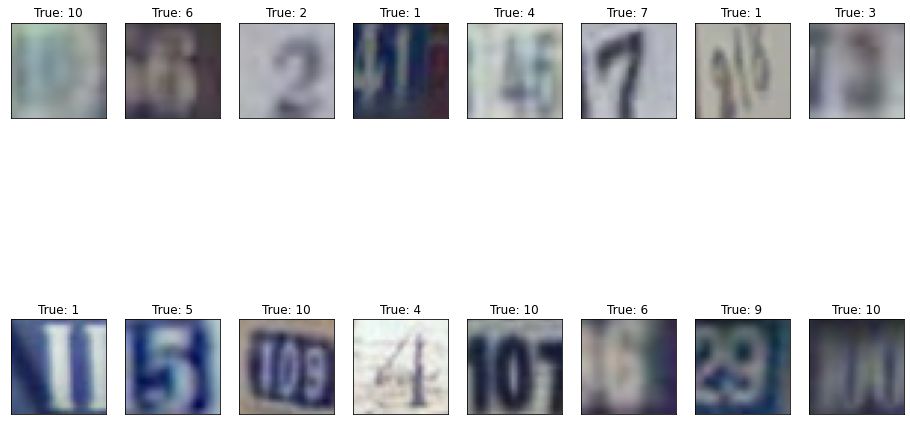

In [0]:
# Plot some training set images
plot_images(X_train, 2, 8, y_train)

Plot Some Images to see the Testing Data

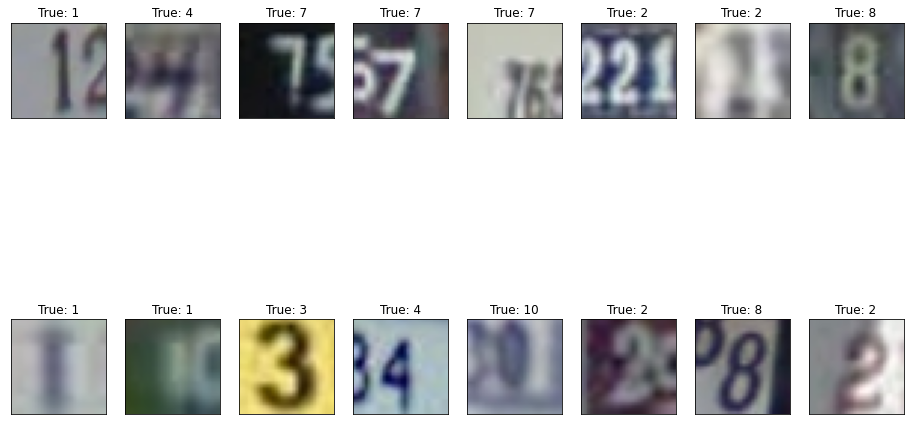

In [0]:
# Plot some test set images
plot_images(X_test, 2, 8, y_test)

check unique labels

In [0]:
print(np.unique(y_train))

[ 1  2  3  4  5  6  7  8  9 10]


Check the distribution of Classes in Train and test

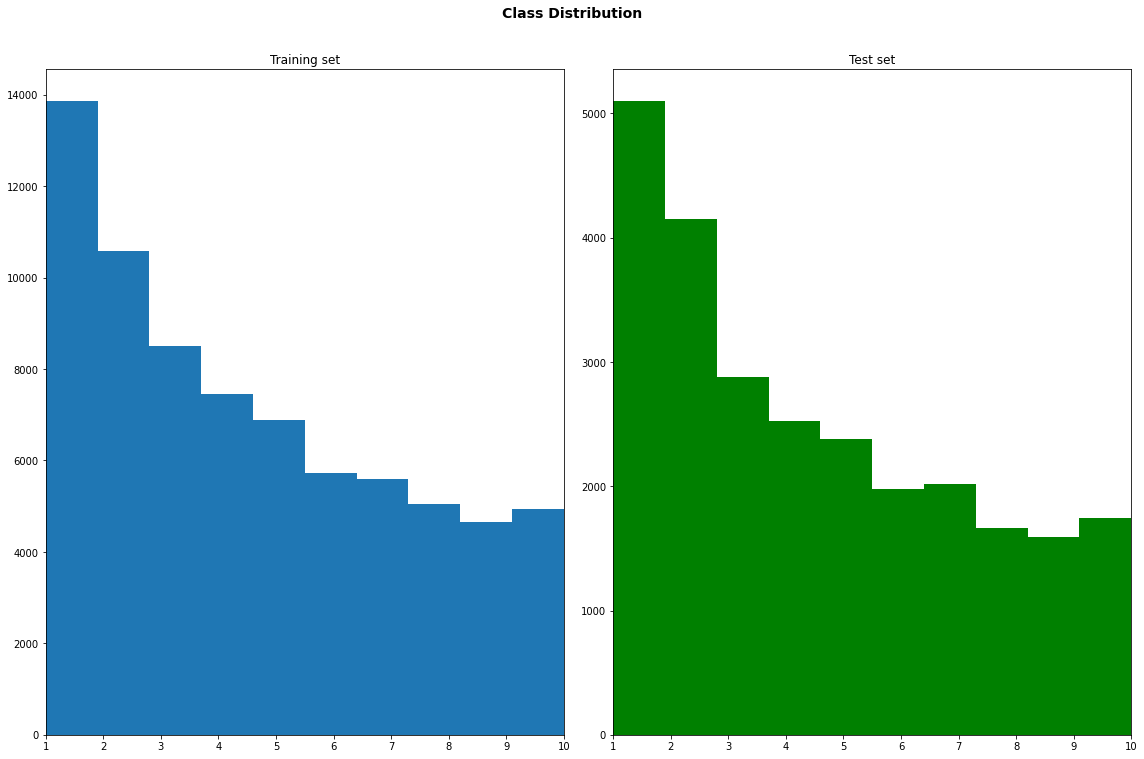

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

fig.suptitle('Class Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist(y_train, bins=10)
ax1.set_title("Training set")
ax1.set_xlim(1, 10)

ax2.hist(y_test, color='g', bins=10)
ax2.set_title("Test set")

fig.tight_layout()


A positive skewed distribution of classes. Higher classes are less in number in both train and test sets


#### Converting Label 10 -> 0

In [0]:
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

In [0]:
print(np.unique(y_train))

[0 1 2 3 4 5 6 7 8 9]


In [0]:
X_train.shape

(73257, 32, 32, 3)

In [0]:
num_classes = 10 # total classes (0-9 digits).

# Training parameters.
learning_rate = 0.001
training_steps = 15000
batch_size = 128
display_step = 1000

# Network parameters.
conv1_filters = 32 # number of filters for 1st conv layer.
conv2_filters = 64 # number of filters for 2nd conv layer.
conv3_filters = 128 # number of filters for 2nd conv layer.
fc1_units = 512 # number of neurons for 1st fully-connected layer.
fc2_units = 1024 # number of neurons for 2st fully-connected layer.

In [0]:
X_train= tf.cast(X_train, tf.float32)
X_test = tf.cast(X_test, tf.float32)

# Normalising pixels between 0 to 1
X_train, X_test = X_train / 255., X_test / 255.

Image Augmentation is done to improve accuracy and also to predict rotated images as in 100 Test images

**# Randomly augment images. Especially rotating 90,180,270 degrees**

In [0]:
# Randomly augment images. Especially rotating 90,180,270 degrees
def augment(image,label):
  rand = tf.random.uniform([])
  if(rand <= 0.25):
    image = tf.image.adjust_saturation(image, 3) # Adjust Saturation
    image = tf.image.flip_left_right(image) #  flip
    image = tf.image.adjust_brightness(image, delta=0.5) #  brightness
    image = tf.image.adjust_contrast(image, contrast_factor= 2) # Contrast
    image = tf.image.rot90(image, k=1, name=None) # Rotate by 90 Degree
  elif(rand > 0.25 and rand <= 0.50):
    image = tf.image.adjust_saturation(image, 3)
    image = tf.image.flip_left_right(image) #  flip
    image = tf.image.adjust_brightness(image, delta=0.5) #  brightness
    image = tf.image.adjust_contrast(image, contrast_factor= 2)
    image = tf.image.rot90(image, k=2, name=None) # Rotate by 180 Degree
  elif(rand > 0.50 and rand <= 0.75):
    image = tf.image.adjust_saturation(image, 3)
    image = tf.image.flip_left_right(image) #  flip
    image = tf.image.adjust_brightness(image, delta=0.5) #  brightness
    image = tf.image.adjust_contrast(image, contrast_factor= 2) 
    image = tf.image.rot90(image, k=3, name=None) # Rotate by 270 Degree
  else:
    # Return the same image
    pass
  return image,label

In [0]:
 # Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((X_train,y_train))
train_data = train_data.repeat().shuffle(5000).map(augment).batch(batch_size).prefetch(1) #Augment the training data in batches

test_data = tf.data.Dataset.from_tensor_slices((X_test,y_test))
test_data = test_data.batch(batch_size)

In [0]:
# Create some wrappers for simplicity.
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation.
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    # MaxPool2D wrapper.
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

In [0]:
# Store layers weight & bias

# A random value generator to initialize weights.
random_normal = tf.initializers.RandomNormal()

weights = {
    # Conv Layer 1: 5x5 conv, 1 input, 32 filters (MNIST has 1 color channel only).
    'wc1': tf.Variable(random_normal([5, 5, 3, conv1_filters])),
    # Conv Layer 2: 5x5 conv, 32 inputs, 64 filters.
    'wc2': tf.Variable(random_normal([5, 5, conv1_filters, conv2_filters])),
    # Conv Layer 3: 3x3 conv, 64 inputs, 128 filters.
    'wc3': tf.Variable(random_normal([3, 3, conv2_filters, conv3_filters])),
    # FC1 Layer 1: 4*4*128 inputs, 512 units.
    'wd1': tf.Variable(random_normal([4*4*128, fc1_units])),
    # FC2 Out Layer: 256 inputs, 1024 units (total number of classes)
    'wd2': tf.Variable(random_normal([fc1_units, fc2_units])),
    # FC Out Layer: 512 inputs, 10 units (total number of classes)
    'out': tf.Variable(random_normal([fc2_units, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.zeros([conv1_filters])),
    'bc2': tf.Variable(tf.zeros([conv2_filters])),
    'bc3': tf.Variable(tf.zeros([conv3_filters])),
    'bd1': tf.Variable(tf.zeros([fc1_units])),
    'bd2': tf.Variable(tf.zeros([fc2_units])),
    'out': tf.Variable(tf.zeros([num_classes]))
}

My Model is made up of  with three convolutional neural network layers followed by two fully connected layers and a last softmax output layer

In [0]:
# Create model
def conv_net(x, training = False):
    
    # Input shape: [-1, 32, 32, 3]. A batch of 28x28x1 (grayscale) images.
    x = tf.reshape(x, [-1, 32, 32, 3])

    # Convolution Layer. Output shape: [-1, 32, 32, 32].
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    
    # Max Pooling (down-sampling). Output shape: [-1, 16, 16, 32].
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer. Output shape: [-1, 16, 16, 64].
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    
    # Max Pooling (down-sampling). Output shape: [-1, 8, 8, 64].
    conv2 = maxpool2d(conv2, k=2)
    
    # Convolution Layer. Output shape: [-1, 8, 8, 64].
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    
    # Max Pooling (down-sampling). Output shape: [-1, 4, 4, 128].
    conv3 = maxpool2d(conv3, k=2)

    # Reshape conv2 output to fit fully connected layer input, Output shape: [-1, 8*8*64].
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # Fully connected layer, Output shape: [-1, 256].
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    # Apply ReLU to fc1 output for non-linearity.
    fc1 = tf.nn.relu(fc1)

    # Apply droupout
    if training:
      fc1 = tf.nn.dropout(x=fc1, rate = 0.2, seed = 1 )

    # Fully connected layer, Output shape: [-1, 512].
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    # Apply ReLU to fc1 output for non-linearity.
    fc2 = tf.nn.relu(fc2)

    # Apply droupout
    if training:
      fc2 = tf.nn.dropout(x=fc2, rate = 0.2, seed = 1 )


    # Fully connected layer, Output shape: [-1, 10].
    out = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    # Apply softmax to normalize the logits to a probability distribution.
    return tf.nn.softmax(out)

In [0]:
# Cross-Entropy loss function.
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)
    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# ADAM optimizer.
optimizer = tf.optimizers.Adam(learning_rate)

In [0]:
# Optimization process. 
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = conv_net(x)
        loss = cross_entropy(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = list(weights.values()) + list(biases.values())

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [0]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = conv_net(batch_x, training=True)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))        

step: 1000, loss: 76.029373, accuracy: 0.851562
step: 2000, loss: 60.657364, accuracy: 0.851562
step: 3000, loss: 72.773758, accuracy: 0.789062
step: 4000, loss: 76.367790, accuracy: 0.796875
step: 5000, loss: 55.156097, accuracy: 0.835938
step: 6000, loss: 81.823082, accuracy: 0.742188
step: 7000, loss: 79.779411, accuracy: 0.843750
step: 8000, loss: 47.489857, accuracy: 0.898438
step: 9000, loss: 36.803097, accuracy: 0.882812
step: 10000, loss: 43.031021, accuracy: 0.867188
step: 11000, loss: 46.733780, accuracy: 0.882812
step: 12000, loss: 32.048485, accuracy: 0.882812
step: 13000, loss: 38.008190, accuracy: 0.875000
step: 14000, loss: 30.968128, accuracy: 0.914062
step: 15000, loss: 26.110966, accuracy: 0.929688


In [0]:
# Test model on test set.
test_accuracy = tf.keras.metrics.Accuracy()
acc = []
y_pred = []

for (x, y) in test_data:
  prediction = conv_net(x)
  pred = np.argmax(prediction, axis=1)
  #print(len(pred))
  #correct_prediction = tf.equal(pred, y)
  #accu+= np.sum(correct[correct_prediction == True])
  y_pred.append(pred)
  test_accuracy(pred, y)
  acc.append(test_accuracy.result().numpy())
print("Test set accuracy: {:.3%}".format(sum(acc)/len(acc)))

Test set accuracy: 88.884%


Model behaves decently on test images with an accuracy close to 90%

Flatten the Test Prediction lists of numpy arrays for plotting

In [0]:
def flatten(lists):
    results = []
    for numbers in lists:
        for x in numbers:
            results.append(x)
    return np.asarray(results)

In [0]:
y_pred = flatten(y_pred)
y_pred = (y_pred.T)

In [0]:
y_pred

array([5, 2, 1, ..., 7, 6, 7])

Model Visualization

Plotting Train Actual Images


Plot 3 rows x 6 col images randomly
with their true labels

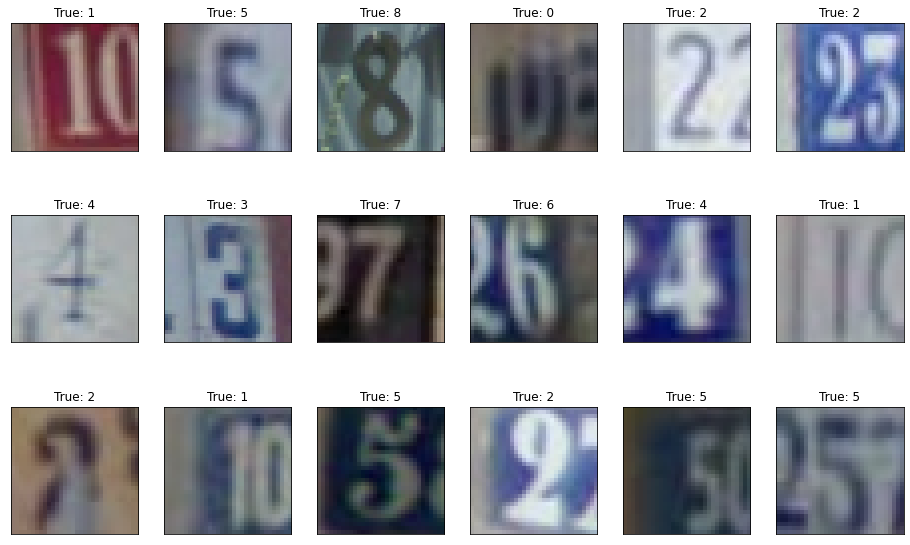

In [0]:
plot_images(X_train, 3, 6, y_train)

Plotting Misclassified results

Plot the misclassfied images of randomly sampled from test set

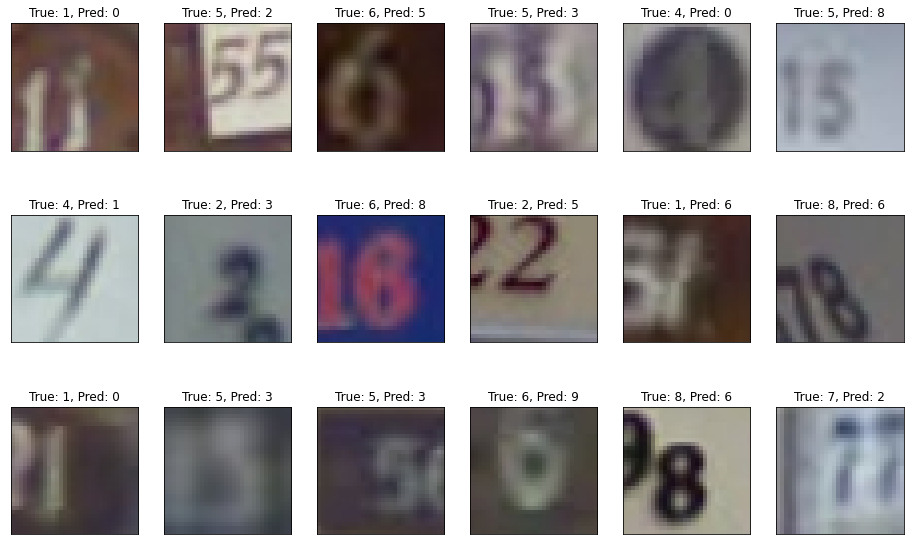

In [0]:
# Find the incorrectly classified examples
#y_pred = np.argmax(pred,axis=1)
incorrect = y_pred != y_test
# Select the incorrectly classified examples
images = X_test[incorrect]
cls_true = y_test[incorrect]
cls_pred = y_pred[incorrect]


# Plot the mis-classified examples
plot_images(images, 3, 6, cls_true, cls_pred);

Plotting Correctly classified results

Plot the correctly classfied images of randomly sampled from test set

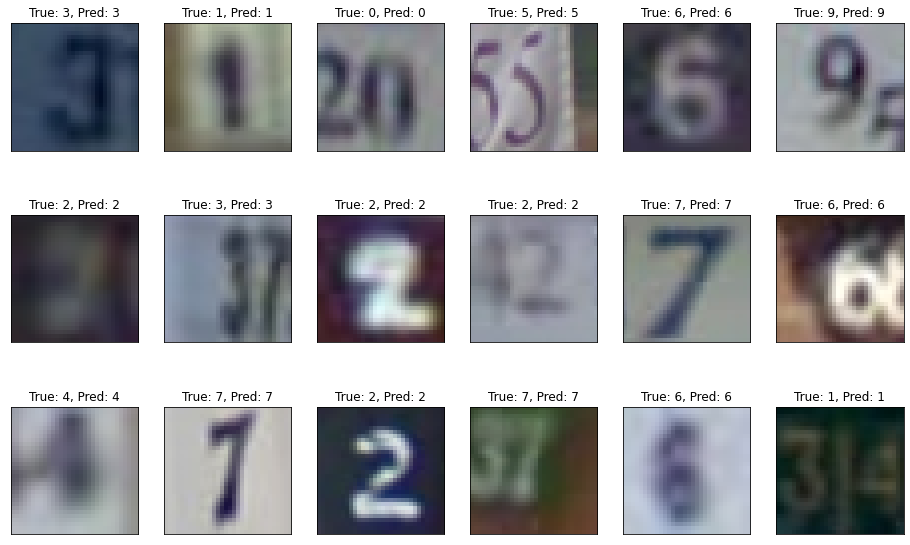

In [0]:
# Find the incorrectly classified examples
correct = np.invert(incorrect)

# Select the correctly classified examples
images = X_test[correct]
cls_true = y_test[correct]
cls_pred = y_pred[correct]

# Plot the mis-classified examples
plot_images(images, 3, 6, cls_true, cls_pred);

Plot Confusion Matrix

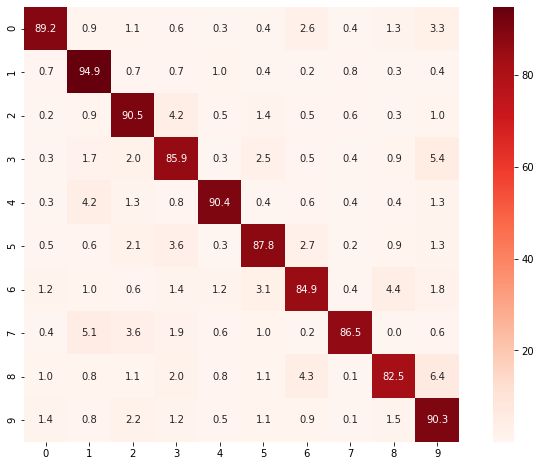

In [0]:
from sklearn.metrics import confusion_matrix

# Set the figure size
plt.figure(figsize=(12, 8))

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, cmap='Reds', fmt='.1f', square=True);

## Testing on 100 Test Images 

In [0]:
TEST_DIR = './SVHN_prediction/testimages/'

In [0]:
if not exists(TEST_DIR):
  !git clone https://github.com/srinath1882/SVHN_prediction.git

In [0]:
x_data = []
img_names = []

for k in os.listdir(TEST_DIR):
  if not k.startswith('.'): # Again avoid hidden folders
# Loop over the images
    img = Image.open(TEST_DIR + k)
    img = img.resize((32,32))
    arr = np.array(img)
    x_data.append(arr) 
    img_names.append(k)
x_data = np.array(x_data, dtype = 'float32')


In [0]:
x_data = x_data/255.

## Plot Images randomly

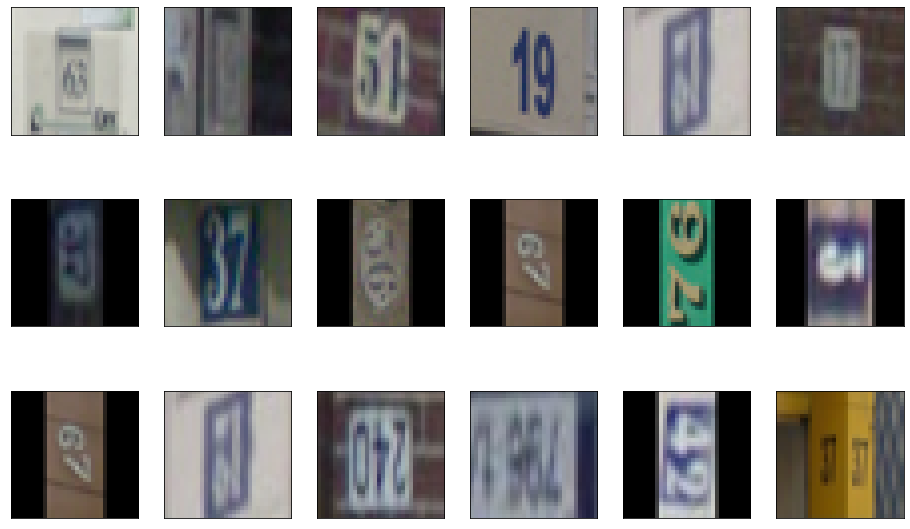

In [0]:
plot_images(x_data, 3, 6)

Make a predition using the model we built 

In [0]:
test_prediction = conv_net(x_data)

In [0]:
test_prediction = tf.argmax(test_prediction, axis = 1)

Lets plot the predictions

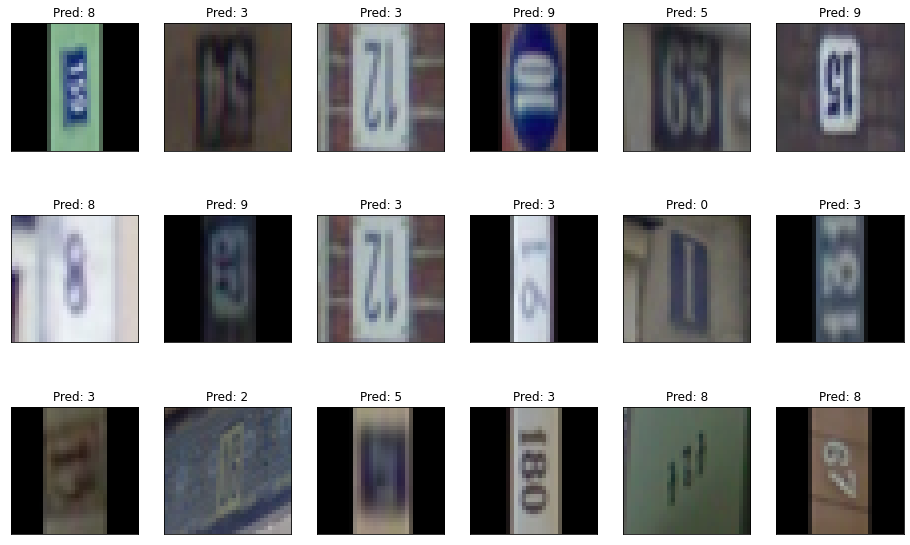

In [0]:
plot_images(x_data, 3, 6, cls_true=None, cls_pred= test_prediction)

Putting as a Data Frame

In [0]:
df = pd.DataFrame([img_names, test_prediction.numpy()])
df = df.T
df.columns = ['Image', 'Predicted Class']

In [0]:
df.head()

,Image,Predicted Class
0,test44.png,1
1,test17.png,7
2,test82.png,3
3,test58.png,9
4,test80.png,8


In [0]:
df.shape

(100, 2)